# Social Media Analysis with Twitter

This is an example of social media analysis using the Twitter public search API following a popular hashtag. I used Python and NLTK's twitter class built upon Twython to view the public feed. The data sample used was 10,000 tweets from the hashtag, "#TaxScamBill" related to a recent tax bill. The goal is to use this analysis to gain insight into the tweets that are connected with the hashtag.  

Some of the interesting findings were the posts were primarily from users that set their location within the United States. The most retweeted post was from a celebrity attempting to shed light into the net neutrality issue as more impactual compared to the tax bill. When clustering the words from the tweets it seems to be noisy reflecting in high recomended clusters and forming clusters related to tax/GOP/republican, the internet/alyssamilano and another related to the senate and legislation. When looking into parts of speech tagging I thought looking at the most frequent verbs would be the most useful to understand the top action or occurrence words. These were "think", "wait", "fight", "resist", and "save"; I feel that these are strong verbs that are opposed to the bill and really interesting to see. It would be great to dive deeper into this analysis to look at similar hashtags used, collect more tweets and be able to perform sentiment analysis to see the perception. 

![](../img/twitter.jpg)

In [1]:
import string
from nltk.twitter.common import json2csv
from nltk import sent_tokenize, word_tokenize
from nltk.twitter import Twitter, TweetWriter, credsfromfile
from spacy.en import STOP_WORDS
from wordcloud import WordCloud
import pandas as pd
import spacy
import textacy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn

nlp = spacy.load('en')
%matplotlib inline

## Twitter

Defines the connection with Twitter. The Tweets get written to a local file in json, I processed this to pull the content, retweet count, if the tweet was retweeted, geo coordinates and the user location.

In [ ]:
tw = Twitter()
tw.tweets(keywords='#TaxScamBill', stream=False, to_screen=False, limit=10000) 

In [2]:
# convert to csv based on the text of the tweet
with open('/Users/brandon/twitter-files/tweets.20171203-112729.json') as fp:
    json2csv(fp, 'tweets_textv2.csv', ['text', 'retweet_count', 'retweeted', 'coordinates', 'user.location'])
    
# grab tweets in a list 
with open('tweets_textv2.csv', 'r') as f:
    tweets = f.readlines()

tweets = pd.read_csv('./tweets_textv2.csv', encoding='utf8')
tweets.head(5)

,text,retweet_count,retweeted,coordinates,user.location
0,@BeauWillimon @Mikel_Jollett The #TaxScamBill ...,0,False,NaN,"Reno, NV"
1,Hondureñxs know how to throw a party against a...,0,False,NaN,Boston
2,RT @BeauWillimon: Don't fall into despair over...,247,False,NaN,NaN
3,RT @lawdavisito94: I’ll be a Ph.D. student in ...,487,False,NaN,"Washington, DC"
4,RT @Alyssa_Milano: You think this #TaxScamBill...,29327,False,NaN,NaN


In [7]:
def cleaning_and_preprocessing(doc):
    """ Function to clean and run the text pre-processing steps.
    1. Lowercase
    2. Punctuation
    3. Stopwords
    4. Stemming
    :param doc: string
    :returns: spacy doc object
    """
    # Lowercase -- can be done in spacy doc object as doc.lower_
    doc = doc.lower()
    
    # Punctuation
    doc = textacy.preprocess.remove_punct(doc)
    
    # Stemming/lemmatization
    doc = [w.lemma_ for w in nlp(doc)]
    
    # Stopwords (using spacy stopwords)
    doc = [w for w in doc if not w in spacy.en.STOP_WORDS]
    
    # Custom stopwords to remove
    rm = ['rt', '-PRON-', ' ', '      ', '   ', '   ', '   ']
    doc = [w for w in doc if not w in rm]
    
    # Additional normalization using textacy
    doc = [textacy.preprocess_text(w) for w in doc]
    
    return doc


def pandas_cleaning_and_preprocessing(doc):
    """ Function to clean and run the text pre-processing steps. Updated to pandas
    1. Lowercase
    2. Punctuation
    3. Stopwords
    4. Stemming
    :param doc: string
    :returns: spacy doc object
    """
    # Lowercase -- can be done in spacy doc object as doc.lower_
    doc = doc.lower()
    # Punctuation
    doc = textacy.preprocess.remove_punct(doc)
    # Stemming/lemmatization
    doc = [w.lemma_ for w in nlp(doc)]
    # Stopwords (using spacy stopwords)
    doc = [w for w in doc if not w in spacy.en.STOP_WORDS]
    # Custom stopwords to remove
    rm = ['rt', '-PRON-', ' ', '      ', '   ', '   ', '   ']
    doc = [w for w in doc if not w in rm]
    # Additional normalization using textacy
    doc = [textacy.preprocess_text(w) for w in doc]
    
    return ' '.join(doc)

### Top User Locations

The user location attribute is defined from the user based on their profile, since this is a text entry I don't expect the string to be normalized in anyway. Since this hashtag relates to the United States tax policies I expect majority of the top locations to be cities/states within the US. However it would be interesting to see if users from outside the US are engaged on a topic like this. 

United States          344
USA                    110
California, USA         99
Florida, USA            76
Texas, USA              69
Los Angeles, CA         56
Washington, DC          55
Chicago, IL             51
New York                50
New York, NY            49
New York, USA           48
Pennsylvania, USA       42
Michigan, USA           38
Colorado, USA           38
California              36
Houston, TX             34
North Carolina, USA     34
Massachusetts, USA      33
Earth                   32
NYC                     32
Name: user.location, dtype: int64

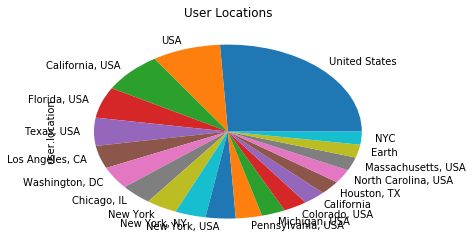

In [4]:
top_usr_loc = tweets['user.location'].value_counts()[:20]
top_usr_loc.plot(kind='pie', title='User Locations')
top_usr_loc

### Most Retweeted Post

Another possibly interesting thing to mine from the data is the top retweeted post. This is expected to either be something highly controversial or possibly from a celebrity or influencer on the platform. The most retweeted post in the sample was users retweeting Alyssa Milano's tweet comparing the impact of the tax bill to net neutrality. 

In [5]:
tweets.sort_values('retweet_count', ascending=False).head(1)
print(tweets.iloc[8053]['text'])

RT @Alyssa_Milano: You think this #TaxScamBill is bad? Wait until they take the internet from you and give it to big corporations. Notice t…


### Clustering Words 

In [8]:
# clean and process
tweets['cleaned_text'] = tweets.text.apply(pandas_cleaning_and_preprocessing)
tweets.head()

tfidf_vector = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
x_data = tfidf_vector.fit_transform(tweets['cleaned_text'])

In [9]:
# using 8 clusters at the found elbow -- note noisey data like twitter may not cluster neatly
clf = KMeans(n_clusters=8)
labels = clf.fit(x_data)
print(labels.labels_[60:100])

[7 6 0 0 1 0 6 0 0 0 6 0 0 0 4 0 0 6 0 0 0 0 0 0 6 0 0 3 0 0 0 0 0 0 0 0 3
 0 0 0]


In [10]:
vocab_frame = pd.DataFrame({'words': tfidf_vector.get_feature_names()[:]}, 
                           index = tfidf_vector.get_feature_names()[:])
order_centroids = clf.cluster_centers_.argsort()[:, ::-1] 

for i in range(8):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :20]: 
        print(' %s' % vocab_frame.ix[tfidf_vector.get_feature_names()[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print('\n')

Cluster 0 words: b'gop', b'people', b'tax', b'amp', b'pass', b'republican', b'lobbyist', b'vote', b'funder', b'donor', b'campaign', b'tweet', b'save', b'prison', b'intermingle', b'wri', b'year', b'house', b'pay', b'senate',

Cluster 1 words: b'internet', b'alyssamilano', b'notice', b'wait', b'bad', b'big', b'corporation', b'think', b'formal', b'foxbusiness', b'foxandfriend', b'fox', b'fourth', b'forward', b'forum', b'forget', b'form', b'forever', b'foreigner', b'forcibly',

Cluster 2 words: b'allow', b'talbertswan', b'lawmaker', b'ram', b'pa', b'entire', b'yes', b'read', b'senate', b'time', b'gop', b'dictate', b'draconian', b'administrat', b'special', b'legislation', b'support', b'chrisjzullo', b'republican', b'foreigner',

Cluster 3 words: b'vote', b'httpstcom58unla3ap', b'thedemocrat', b'kick', b'ready', b'office', b'richardschiff', b'violate', b'taxb', b'retweet', b'saturdaymorn', b'senator', b'america', b'night', b'republican', b'forget', b'force', b'forever', b'form', b'foreigner'

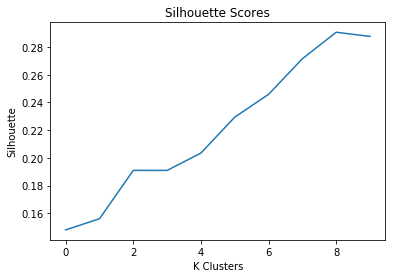

In [11]:
# finding k
sil_scores = []

for n_clusters in range(2,12):
    km = KMeans(n_clusters=n_clusters)
    km.fit(x_data)
    
    labels = km.labels_
    centr = km.cluster_centers_
    # Need to use smaller sample size -- runs out of memory and crashes kernel
    sil_scores.append(silhouette_score(x_data, labels, metric='euclidean', sample_size=2000))
    
plt.plot(sil_scores)
plt.title('Silhouette Scores')
plt.ylabel('Silhouette')
plt.xlabel('K Clusters')
plt.show()

### Top Words

#### Verbs 



Frequent verbs for the corpus: 

think     1573
wait      1327
pass       420
fight      418
let        414
write      373
read       370
resist     340
save       307
hit        293
dtype: int64


(-0.5, 399.5, 199.5, -0.5)

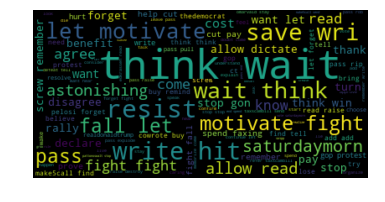

In [12]:
# Most frequent VERBS in the combined tweets. 
corpus = ' '.join(tweets['text'])
print('\n\nFrequent verbs for the corpus: \n')
# Most frequent verb (action, occurance or state)
verbs = [token.text for token in nlp(' '.join(cleaning_and_preprocessing(corpus))) if token.pos_ == 'VERB']
print(pd.Series(verbs).value_counts()[:10])

wordcloud = WordCloud().generate(' '.join(verbs))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### View Geo Coordinates (NOT ENOUGH DATA)

Unfortunately the only geo coordinate tags functioning in the API are the "coordinates" which is set explicitly by the user when posting their tweet. From my sample of 10,000 tweets I only had a single result containing usable geo tag. Any visual would't be very helpful.

In [14]:
tweets.sort_values('coordinates', ascending=True).head()

,text,retweet_count,retweeted,coordinates,user.location,cleaned_text
3741,Like your Republican cronies just did with the...,2,False,"{'type': 'Point', 'coordinates': [-95.366241, ...","Houston, TX",like republican crony taxscambill httpstcoxtar...
0,@BeauWillimon @Mikel_Jollett The #TaxScamBill ...,0,False,NaN,"Reno, NV",beauwillimon mikeljollett taxscambill senate n...
1,Hondureñxs know how to throw a party against a...,0,False,NaN,Boston,hondureñx know throw party corrupt government ...
2,RT @BeauWillimon: Don't fall into despair over...,247,False,NaN,NaN,beauwillimon fall despair taxscambill let moti...
3,RT @lawdavisito94: I’ll be a Ph.D. student in ...,487,False,NaN,"Washington, DC",lawdavisito94 ill phd student 2019 taxscambill...


### Future Work

Analyzing data like this could uncover some really interesting insights, I would absolutely recommend the next steps going into sentiment analysis. This could easily sort and get the overall sentiment of issues and events which is massively useful for social media platforms. Another interesting route to take might be clustering based on spans of text from the tweets along with the words as shown above. It might find interesting clusters. An additional interesting step I wanted to look into was plotting where the coordinates were from the tweets. This could be interesting but would most likely require incremental streaming and collecting many more tweets than the sample I used. 

### Resources

* https://marcobonzanini.com/2015/06/16/mining-twitter-data-with-python-and-js-part-7-geolocation-and-interactive-maps/

* Introduction to Machine Learning with Python

* https://dev.to/rodolfoferro/sentiment-analysis-on-trumpss-tweets-using-python-
    
* https://spacy.io/usage/linguistic-features
    
* https://github.com/brandonserna/Text-Analytics-Samples/blob/master/notebooks/Text%20Clustering.ipynb